In [1]:
import os
import numpy as np
import pandas as pd
import ants
from tqdm import tqdm

In [2]:
ants.__version__

'0.6.1'

In [3]:
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

In [4]:
def max_voxel_coords(volume):
    """
    Given a 3D NumPy array `volume`, return the (x, y, z) index
    of its maximum element.

    Parameters
    ----------
    volume : np.ndarray
        3D array of shape (X, Y, Z).

    Returns
    -------
    coords : tuple of int
        The (x, y, z) indices of the maximum value in `volume`.
    """
    # Find the flat index of the maximum
    flat_idx = np.argmax(volume)
    # Convert flat index into 3D coordinates
    return tuple(np.unravel_index(flat_idx, volume.shape))

In [5]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

In [6]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
n_orig = len(subs)
n_orig

34

In [7]:
#'../Data/StudyForrest/ensembles_last_CVAE/162-refac-baseline-1-ABCD-TC-nopreclean/'

In [8]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
#analysis_name = 'refactored-ABCD-v4'
#analysis_name = 'refactored-ABCD-v5-nopreclean'
#analysis_name = '162-refac-baseline-1-ABCD-TC-nopreclean'
#analysis_name = '162-refac-baseline-1-ABCD-nopreclean'
#analysis_name = '162-refac-baseline-1-ABCD-beta-1e-5'
#analysis_name = '162-refac-baseline-1-ABCD-nopreclean
#analysis_name = '162-refac-baseline-1-ABCD-TC-nopreclean'
#analysis_name = 'DeepCor-ABCD-nopreclean-beta-1e-5'
analysis_name = 'DeNN-ABCD-neurips-v2'

ofdir = os.path.join(ofdir_root,analysis_name)

In [9]:
# conf_fn_format = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
# events_fn_temp = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')

## Make indiv ROIs Face

In [10]:
roi_dir = '../Data/ABCD-indiv-ROIs/'

In [11]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

do_make_rois = False
if do_make_rois:
    atype = 'contrast_face'
    kind = 'compcor'
    sphere_dim = 5
    nvoxels = 100
    xyz = (67,35,27)
    
    files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if all((file.startswith(f'{atype}_'),file.endswith(f'_{kind}.nii.gz')))]
    files.sort()
    
    arr = np.array([ants.image_read(file).numpy() for file in files]).mean(axis=0)
    xyz = max_voxel_coords(arr)
    im = ants.image_read(files[0]).new_image_like(arr)
    im.to_filename(os.path.join(ofdir,f'{atype}_{kind}_grandavg.nii.gz'))
    im.to_filename(os.path.join(roi_dir,f'{atype}_{kind}_grandavg.nii.gz'))
    
    temp = ants.image_read('../Misc/single_subj_T1.nii')
    
    temp.plot_ortho(im,flat=True,xyz=xyz)
    im_sphere = im.new_image_like(sphere(im.shape,sphere_dim,xyz)*1.0)
    im_sphere.to_filename(os.path.join(ofdir,'sphere.nii'))
    print(im_sphere.numpy().sum())
    temp.plot_ortho(im_sphere,flat=True,xyz=xyz)

    for s in range(33):
        
        sphere = ants.image_read(os.path.join(ofdir,'sphere.nii'))
        im_c = [ants.image_read(os.path.join(ofdir,f'{atype}_{s}_R{r}_{kind}.nii.gz')) for r in [1,2]]
        im_c = im_c[0].new_image_like(np.array([val.numpy() for val in im_c]).mean(axis=0))
    
        critval = np.sort(im_c.numpy()[sphere.numpy()==1].flatten())[-nvoxels-1]
        indiv_roi = (im_c.numpy()>critval) * sphere.numpy()==1
        im_indiv_roi = im_c.new_image_like(indiv_roi)
        im_indiv_roi.to_filename(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        
    files = [os.path.join(roi_dir,file) for file in os.listdir(roi_dir) if file.startswith('FFA-ROI')]
    ims = [ants.image_read(file) for file in files]
    ims[0].new_image_like(np.array([im.numpy() for im in ims]).sum(axis=0)).to_filename(os.path.join(roi_dir,'GroupMap-FFA.nii'))
    temp.plot_ortho(ants.image_read(os.path.join(roi_dir,'GroupMap-FFA.nii')),flat=True,xyz=xyz)

In [12]:
res = np.zeros((2,33,3))
for s in range(33):
    for r in [1,2]:
        # im_p = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_deepcor.nii.gz'))
        
        im_p = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_deepcor.nii.gz'))

        
        roi = ants.image_read(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()

face_res = res.copy()
np.save(f'../Data/corr2face_{analysis_name}.npy',face_res)

In [13]:
res = np.zeros((2,33,3))
for s in range(33):
    for r in [1,2]:
        im_p = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'contrast_face_{s}_R{r}_deepcor.nii.gz'))
        
        # im_p = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_deepcor.nii.gz'))

        
        roi = ants.image_read(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()

face_res = res.copy()
np.save(f'../Data/contrast_face_{analysis_name}.npy',face_res)

In [14]:
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel

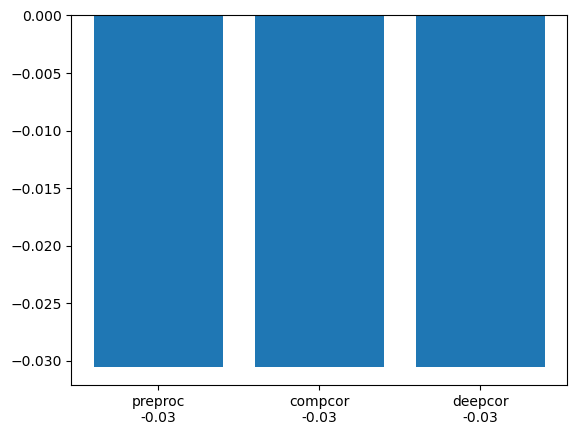

In [15]:
ys = res.mean(axis=0).mean(axis=0)
xs = [0,1,2]
plt.bar(xs,ys)
lbls = ['preproc','compcor','deepcor'];
lbls = [lbls[i]+'\n'+f'{ys[i]:.2f}' for i in range(len(ys))];
plt.xticks(xs,labels=lbls);

In [16]:
res.mean(axis=0).mean(axis=0).round(2)

array([-0.03, -0.03, -0.03])

In [17]:
avg = res.mean(axis=0).mean(axis=0)
d1=avg[1]-avg[0]
d2=avg[2]-avg[0]
improvement = ((d2/d1)-1)*100
improvement = improvement.round()
print('improvement: {}%'.format(improvement))
ttest_rel(res.mean(axis=0)[:,2],res.mean(axis=0)[:,1])

improvement: nan%


/tmp/ipykernel_624938/405988848.py:4: RuntimeWarning: invalid value encountered in double_scalars
  improvement = ((d2/d1)-1)*100


Ttest_relResult(statistic=nan, pvalue=nan)

In [18]:
diff = np.array(res[:,:,2]-res[:,:,0])
((diff<-1).sum()/np.prod(diff.shape)).round(2)

0.0

## Make indiv ROIs Place

In [19]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0


do_make_rois = False
if do_make_rois:
    atype = 'contrast_place'
    kind = 'compcor'
    sphere_dim = 5
    nvoxels = 100
    xyz = (62,41,34)
    
    
    files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if all((file.startswith(f'{atype}_'),file.endswith(f'_{kind}.nii.gz')))]
    files.sort()
    
    arr = np.array([ants.image_read(file).numpy() for file in files]).mean(axis=0)
    xyz = max_voxel_coords(arr)
    im = ants.image_read(files[0]).new_image_like(arr)
    im.to_filename(os.path.join(ofdir,f'{atype}_{kind}_grandavg.nii.gz'))
    
    temp = ants.image_read('../Misc/single_subj_T1.nii')
        
    temp.plot_ortho(im,flat=True,xyz=xyz)
    im_sphere = im.new_image_like(sphere(im.shape,sphere_dim,xyz)*1.0)
    im_sphere.to_filename(os.path.join(ofdir,'sphere.nii'))
    print(im_sphere.numpy().sum())
    temp.plot_ortho(im_sphere,flat=True,xyz=xyz)
    
    roi_dir = '../Data/ABCD-indiv-ROIs/'
    for s in range(33):
        
        im_sphere = ants.image_read(os.path.join(ofdir,'sphere.nii'))
        im_c = [ants.image_read(os.path.join(ofdir,f'{atype}_S{s}_R{r}_{kind}.nii.gz')) for r in [1,2]]
        im_c = im_c[0].new_image_like(np.array([val.numpy() for val in im_c]).mean(axis=0))
    
        critval = np.sort(im_c.numpy()[im_sphere.numpy()==1].flatten())[-nvoxels-1]
        indiv_roi = (im_c.numpy()>critval) * im_sphere.numpy()==1
        im_indiv_roi = im_c.new_image_like(indiv_roi)
        im_indiv_roi.to_filename(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        
    files = [os.path.join(roi_dir,file) for file in os.listdir(roi_dir) if file.startswith('PPA-ROI')]
    ims = [ants.image_read(file) for file in files]
    ims[0].new_image_like(np.array([im.numpy() for im in ims]).sum(axis=0)).to_filename(os.path.join(roi_dir,'GroupMap-PPA.nii'))
    temp.plot_ortho(ants.image_read(os.path.join(roi_dir,'GroupMap-PPA.nii')),flat=True,xyz=xyz)

In [20]:
res = np.zeros((2,33,3))
for s in range(33):
    for r in [1,2]:
        # im_p = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_deepcor.nii.gz'))
        
        im_p = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_deepcor.nii.gz'))

        roi = ants.image_read(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()
        
place_res = res.copy()
np.save(f'../Data/corr2place_{analysis_name}.npy',place_res)

In [21]:
res = np.zeros((2,33,3))
for s in range(33):
    for r in [1,2]:
        im_p = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_deepcor.nii.gz'))
        
        # im_p = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_deepcor.nii.gz'))

        roi = ants.image_read(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()
        
place_res = res.copy()
np.save(f'../Data/contrast_place_{analysis_name}.npy',place_res)

[0.00492209 0.00492209 0.00492209]
improvement: nan%


/tmp/ipykernel_624938/1706125855.py:12: RuntimeWarning: invalid value encountered in double_scalars
  improvement = ((d2/d1)-1)*100


Ttest_relResult(statistic=nan, pvalue=nan)

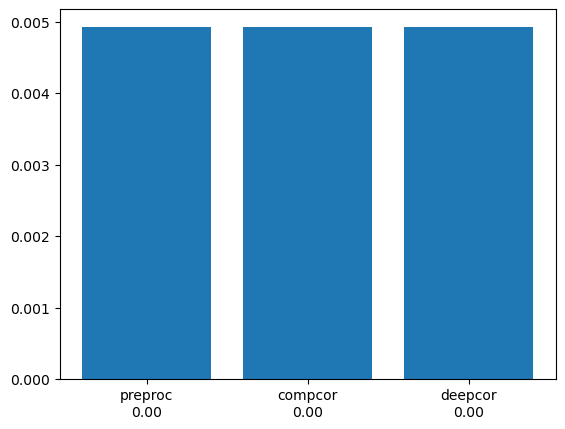

In [22]:
ys = res.mean(axis=0).mean(axis=0)
xs = [0,1,2]
plt.bar(xs,ys)
lbls = ['preproc','compcor','deepcor'];
lbls = [lbls[i]+'\n'+f'{ys[i]:.2f}' for i in range(len(ys))];
plt.xticks(xs,labels=lbls);

avg = res.mean(axis=0).mean(axis=0)
print(avg)
d1=avg[1]-avg[0]
d2=avg[2]-avg[0]
improvement = ((d2/d1)-1)*100
improvement = improvement.round()
print('improvement: {}%'.format(improvement))
ttest_rel(res.mean(axis=0)[:,2],res.mean(axis=0)[:,1])

In [23]:
# diff = np.array(res[:,:,2]-res[:,:,0])
# ((diff<1).sum()/np.prod(diff.shape)).round(2)

In [24]:
# indir = '../Data/020-fmriprepped'
# subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
# subs.sort()
# n_orig = len(subs)
# print(n_orig)

# rvec = [1,2]
# mot = np.zeros((len(rvec),len(subs)))
# for s in range(len(subs)):
#     for r in rvec:
#         sub = subs[s]
#         #sess_name = 'ses-localizer2' if sub=='sub-01' else 'ses-localizer1'
#         #fn = os.path.join(indir,sub,sess_name,'func',f'{sub}_{sess_name}_task-6cat_run-{r:02d}_desc-confounds_timeseries.tsv')
#         fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
#         df = pd.read_csv(fn,delimiter='\t')
#         fd = df['framewise_displacement'][1::]
#         #mot[r-1,s]=fd.sum()
#         mot[r-1,s]=fd.mean()
#         #mot[r-1,s]=(fd>.2).sum()
#         #mot[r-1,s]=fd.max()
# print(mot)
# #np.save('../Data/mot_ABCD.npy',mot)

In [25]:
# vals = face_res[:,:,2]-face_res[:,:,0]
# #vals = place_res[:,:,2]-place_res[:,:,0]
# vals = vals[:,0:33]
# mot = mot[:,0:33]

In [26]:
#np.corrcoef(mot.flatten(),vals.flatten())[0,1]

In [27]:
#plt.scatter(vals.flatten(),mot.flatten())
#plt.scatter(mot.flatten(),vals.flatten())

In [28]:
# mot = np.zeros((len(rvec),len(subs_orig)))
# for s in range(3):
#     for r in rvec:
#         sub = subs_orig[s]
#         sess_name = 'ses-localizer2' if sub=='sub-01' else 'ses-localizer1'
#         fn = os.path.join(indir,sub,sess_name,'func',f'{sub}_{sess_name}_task-6cat_run-{r:02d}_desc-confounds_timeseries.tsv')
#         df = pd.read_csv(fn,delimiter='\t')
#         fd = df['framewise_displacement'][1::]
#         #mot[r-1,s]=fd.sum()
#         #mot[r-1,s]=fd.mean()
#         mot[r-1,s]=(fd>.5).sum()
#         #mot[r-1,s]=fd.max()
# print(mot)
# #vals = res[:,:,2]-res[:,:,0]